In [1]:
# General
import os
import re
import sklearn
import nltk
import numpy as np
import pandas as pd
import contractions
# Preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim 
from gensim.models import Word2Vec 
# models
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
import seaborn as sns
# Enable inline plotting  
%matplotlib inline

/Users/mahzadkhoshlessan/miniconda3/envs/omdena/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Limitations of topic models

Topic models have become a standard tool within quantitative text analysis for many different reasons. Topic models can be much more useful than simple word frequency or dictionary based approaches depending upon the use case. Topic models tend to produce the best results when applied to texts that are not too short (such as tweets), and those that have a consistent structure.

In [2]:
data1 = pd.read_csv('train/tweet_global_warming.csv',error_bad_lines=False,engine='python')
data2 = pd.read_csv('train/weather-evaluated-agg-DFE.csv',encoding='utf-8')
data3 = pd.read_csv('train/sentiment_nuclear_power.csv',error_bad_lines=False,engine='python')

In [3]:
data = pd.concat([data1['tweet'],data2['tweet_text'],data3['tweet_text']],axis=0)
data = shuffle(data)
data.index = range(len(data))

In [4]:
data.head()

0    A Necessary Reflection on the Climate Change M...
1    Support for carbon tax plan|Key supporters of ...
2    #WEATHER:  3:53 am : 57.0F. Feels 55F. 29.98% ...
3    It's gonna rain in #SanFrancisco tmr. I need t...
4    RT @EnergyBoom: Harvard and MIT Receive $2 Mil...
dtype: object

## Preprocess

In [5]:
stopword = stopwords.words('english') 

In [6]:
def stemming(words):
    ps = nltk.stem.SnowballStemmer('english')
    new = []
    stem_words = [ps.stem(x) for x in words]
    return stem_words

In [7]:
def preprocess(sentence):
    sentence = contractions.fix(sentence)             # Replace contractions in string 
    sentence = re.sub('@\w+',"",str(sentence))        # remove mentions
    sentence = re.sub('#\w+',"",str(sentence))        # remove hashtags
    sentence = re.sub('http\S+',"",str(sentence))     # remove URLs
    sentence = re.sub('[^\w\s]'," ",str(sentence))    # remove punc
    sentence = re.sub('[^a-zA-Z]'," ",str(sentence))  # remove numbers
  
    sents = word_tokenize(sentence)                   # Tokenization
    sents = stemming(sents)
            
    new_sents = ""
    for i in range(len(sents)):                       # remove stopwords            
        if(sents[i].lower() not in stopword and sents[i]!='rt' and len(sents[i])>1):
            new_sents += sents[i].lower()+" "
    new_sents.strip()
    
    return new_sents

In [8]:
def preprocessing(xtrain):
    corpus = xtrain.apply(preprocess)
    return corpus

In [9]:
corpus = preprocessing(data)
corpus = corpus.drop_duplicates() 

## Feature Extraction

In [10]:
def featureextraction(corpus):
    
    vectorizer = TfidfVectorizer(max_df=.5,min_df=1,max_features=None,ngram_range=(1, 2),norm=None,binary=True,
                             use_idf=False,sublinear_tf=False,strip_accents = 'unicode',stop_words = 'english')
    vectorizer = vectorizer.fit(corpus)
    tfidf = vectorizer.transform(corpus)
    vocab = vectorizer.get_feature_names()

    return tfidf, vocab

In [11]:
tfidf, vocab = featureextraction(corpus)

## Correlated Topic Modeling

Here are the references:<br>
https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb
https://github.com/JoanneBurke/NLP-Projects

In [12]:
TOPICS = 20
NBR_OF_WORDS = 30

In [13]:
model = ct.Corex(n_hidden=TOPICS, seed=42,count='fraction')
model = model.fit(tfidf,docs=corpus,words=vocab)

### Overall TC

In [14]:
model.tc

21.696553962608807

### Topic TC

TC is a way to compare the strength of different topics. TC does tell us which topic is much more informative as compared to others.

In [62]:
list(map(int,range(model.tcs.shape[0])))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

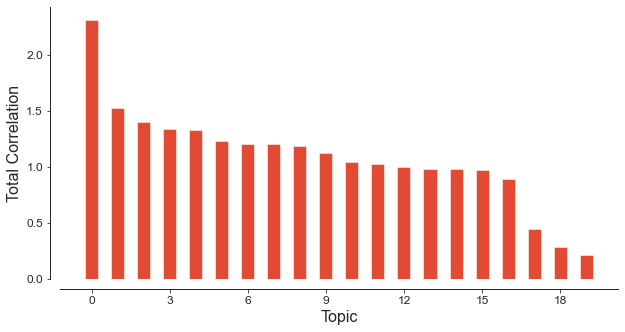

In [63]:
from matplotlib.ticker import MaxNLocator 

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(list(map(int,range(model.tcs.shape[0]))), model.tcs, width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation', fontsize=16);
plt.style.use('ggplot')
sns.set_style('ticks')
plt.rcParams['font.size'] = 12
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.set_xlabel('Processor Ranks')   
# ax.set_ylabel('Total Time (s)')
sns.despine(offset=10, ax=ax)
fig.savefig('{}.png'.format('crr'), bbox_inches='tight')

In [16]:
topics = model.get_topics()
for topic_n,topic in enumerate(topics):
    words,mis = zip(*topic)
    topic_str = str(topic_n+1)+': '+','.join(words)
    print(topic_str)

1: climat chang,chang,climat,warm,global warm,global,weather,chang link,storm,snow
2: trial,clinic,chang clinic,clinic trial,collagen,trial collagen,scream climat,scream,cliniqu,collagen cliniqu
3: park,fox,fox news,await,effect climat,long await,effect,year ago,disput,nation park
4: volcano,caus,iceland,volcan,iceland volcano,melt,warm caus,erupt,limbo,chang limbo
5: confer,peopl,world,bolivia,confer climat,peopl confer,world peopl,sec,chang right,peopl world
6: warm mean,mean,becaus,warm becaus,mean snow,ago global,cold dc,jr month,cancer,becaus cancer
7: palin,snake oil,snake,oil,sarah palin,oil scienc,sarah,palin global,nws,travel
8: snow patrol,patrol,snow mean,barack obama,hansen,salti,barack,architect,gingrich,fossil fuel
9: clean,hide,hide declin,ceo,extrem,militari lead,lead fight,clean energi,pm cdt,sea
10: chang sceptic,quiz,effici,quiz climat,bp press,headlin polic,energi headlin,googl,wood,polic quiz
11: warm law,wind,mph,law,feel humid,humid,humid mph,california global,cl

In [17]:
top_docs = model.get_top_docs()
for topic_n, topic_docs in enumerate(top_docs):
    docs,probs = zip(*topic_docs)
    topic_str = str(topic_n+1)+': '+','.join(docs)
    print(topic_str)

1: lord smith warn climat chang argument undermin climateg fight tackl climat chang ,latest blog nick bridg wonder major weather event affect percept climat chang ,post upcom webinar sec recent hear regard disclosur climat chang busi impact ,miss heat may affect futur climat chang humanitarian news via ,bet climat chang link ,frontlin climat chang joseph huff hannon comment free gua via ,uruguay tool need vulner climat chang global geopolit net site ip acosta ,chang climat climat chang intent purpos realist prospect treati ,committe utah legislatur pass climat chang deni resolut ,mediaglob report special tip point earth day event scienc art mobil fight climat chang link 
2: retro video game consol valentin day gift scream climat chang clinic trial collag link ,key fix global warm china link ,pollster rapid collaps public belief man made global warm veri unusu inde see ,brilliant tip valentin day scream climat chang clinic trial collagen cliniqu clip link ,global warm activist snowmaged

In [18]:
vt.vis_rep(model, data=tfidf, column_label=vocab, prefix='topic-model-example')

Print topics in text file


In [ ]:
# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2 = tm_layer2.fit(model.labels);

# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3 = tm_layer3.fit(tm_layer2.labels);

In [ ]:
from IPython.display import display, Javascript, HTML
import json

In [ ]:
display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
display(Javascript(filename="circles.js"))
display(HTML(filename="circles.css.html"))

In [ ]:
vt.vis_hierarchy([model, tm_layer2, tm_layer3], column_label=vocab, max_edges=200, prefix='topic-model-example')

In [18]:
df_corex = None
df_corex = pd.DataFrame(columns=['topic_num','topic_word','word_weight'])

In [19]:
size = NBR_OF_WORDS

In [20]:
sentences = []
for i in range(TOPICS):
    words,mis = zip(*model.get_topics(n_words=size,topic=i))
    sentences.append(list(words))
#     df = pd.concat([pd.DataFrame([i]*size),pd.DataFrame(model.get_topics(n_words=size,topic=i))],axis=1)
#     df.columns = ['topic_num','topic_word','word_weight']
#     df_corex = pd.concat([df_corex,df],axis=0)

### Using 4grams (or ngrams) for our correlated topic modeling:

In [21]:
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

In [22]:
bigram = Phrases(sentences, min_count=1, threshold=0.8, scoring='npmi')

In [23]:
# trigram = Phrases(bigram[sentences])
# fourgram = Phrases(trigram[sentences])

In [24]:
text = list(bigram[sentences])

In [25]:
model_t = gensim.models.Word2Vec(text, min_count = 1,size = size, window = 5) 

In [26]:
list_names = model_t.wv.vocab

### Ploting the explained variance ratio

In [53]:
def pca_variance(pca,reduc,plot_var):
    var_exp = pca.explained_variance_ratio_*100
    cum_var_exp = np.cumsum(pca.explained_variance_ratio_)*100
    
    if plot_var:
        with plt.style.context('seaborn-whitegrid'):
            fig, ax = plt.subplots(figsize=(6, 4))
            plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center',
                    label='individual explained variance')
            plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',
                     label='cumulative explained variance')
            plt.ylabel('Explained variance ratio')
            plt.xlabel('Principal components')
            plt.xticks(range(len(var_exp)))
            ax.set_xticklabels(np.arange(1, reduc.shape[1] + 1))
     
            plt.style.use('ggplot')
            sns.set_style('ticks')
            plt.rcParams['font.size'] = 12
            ax.set_xlabel('Processor Ranks')   
            ax.set_ylabel('Total Time (s)')
            sns.despine(offset=10, ax=ax)
            plt.tight_layout()
            plt.xticks(rotation=90)
            fig.savefig('{}.png'.format('evr'), bbox_inches='tight')
        
    return var_exp

### Permutation tests 

__VERY HELPFUL RESOURCE__: 
(tSNE and Permutation for PCA) https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868

Permutation Tests is used to determine the optimum number of principal components required for PCA. For more information on benefit of permutation tests and how they work please have a look here:<br>
http://www.win-vector.com/blog/2016/05/pcr_part3_pickk/

The formula used for calculating the p-values here can be found in the following reference:<br>
https://bioconductor.org/packages/devel/bioc/vignettes/ClusterSignificance/inst/doc/ClusterSignificance-vignette.html#score-permutation

In [54]:
def permutation_matrix(arrays,n_perm):
    pca = PCA(n_components=None).fit(arrays)
    reduc = pca.transform(arrays)
    var_exp = pca_variance(pca,arrays,True)
    
    perm_var = np.zeros((n_perm,len(var_exp)))
    index = list(range(len(arrays)))
    arr = arrays.copy()
    
    for i in range(n_perm):
        
        permuted_index = np.random.permutation(index)
        arr[index] = arr[permuted_index]

        pca = PCA(n_components=None).fit(arr)
        reduc = pca.transform(arr)
        perm_var[i,:] = pca_variance(pca,reduc,False)
        arr = arrays.copy()
        
        
    # Calculate score permutation
    L = [np.sum(np.where(perm_var[:,j]>var_exp[j],1,0)) for j in range(len(var_exp))] 
        
    # P-value
    p_val = [x/n_perm if x>0 else 10**(-np.log(10*n_perm )) for x in L]
            
    return p_val, perm_var, var_exp

In [55]:
arrays = np.empty((0, size), dtype='f')
    
for wrd in list_names:
    wrd_vector = model_t.wv.__getitem__([wrd])
    arrays = np.append(arrays, wrd_vector, axis=0)

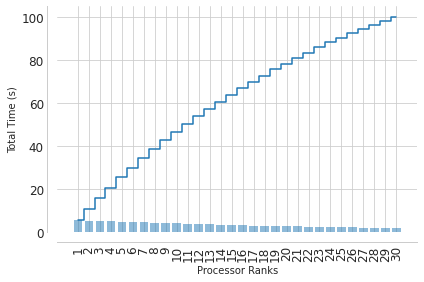

In [56]:
out = permutation_matrix(arrays,10**4)

In the above graph, the blue line represents cumulative explained variance and the blue line represents explained the variance of each principal component. By looking at the graph above, even though the cumulative explained variance line is not perfectly linear, but it is very close to a straight line. Is this good? No. This means each of the principal components contributes to the variance explanation almost equally, and there’s not much point in reducing the dimensions based on PCA. 

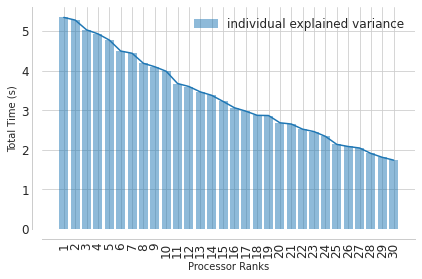

In [57]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.bar(range(len(out[2])), out[2], alpha=0.5, align='center',
            label='individual explained variance')
    plt.plot(range(len(out[2])),np.mean(out[1],axis=0))
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xticks(range(len(out[2])))
    ax.set_xticklabels(np.arange(1, len(out[2]) + 1))
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12
    ax.set_xlabel('Processor Ranks')   
    ax.set_ylabel('Total Time (s)')
    sns.despine(offset=10, ax=ax)
    plt.xticks(rotation=90)
    plt.legend(loc='best')
    plt.tight_layout()
    fig.savefig('{}.png'.format('mevr'), bbox_inches='tight')

Mean of the explained variance ratio of permuted matrices do not really differ from the explained variance ratio of the non-permuted matrix which suggests that applying pca on correlated topic results is not really helpful.

### Finding the optimum number for perplexity

In [33]:
def check_perplexity(perp_list,model,list_names,size):
    fig = plt.figure(figsize=(25,70))
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 15
    
    arrays = np.empty((0, size), dtype='f')
    word_labels = []
    color_list  = []
    
    for wrd in list_names:
        try:
            wrd_vector = model.wv.__getitem__([wrd])
            word_labels.append(wrd)
            color_list.append('green')
            arrays = np.append(arrays, wrd_vector, axis=0)
        except Exception:
            pass
        
    # Reduces the dimensionality with PCA
    pca = PCA(n_components=10).fit(arrays)
    reduc = pca.transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    for i,x in enumerate(perp_list):
        ax = fig.add_subplot(9,3,i+1)
        Y = TSNE(n_components=2, perplexity=x, learning_rate=10,
                  n_iter=500, random_state=0, angle=0.75).fit_transform(reduc)
        
        # Sets everything up to plot
        df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                           'y': [y for y in Y[:, 1]],
                           'words': word_labels,
                           'color': color_list})
        
        ax = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                 'facecolors': df['color']})
        
        ax.set_ylabel('tSNE2')
        ax.set_xlabel('tSNE1')
        ax.set_title('Perplexity = {}'.format(perp_list[i]))

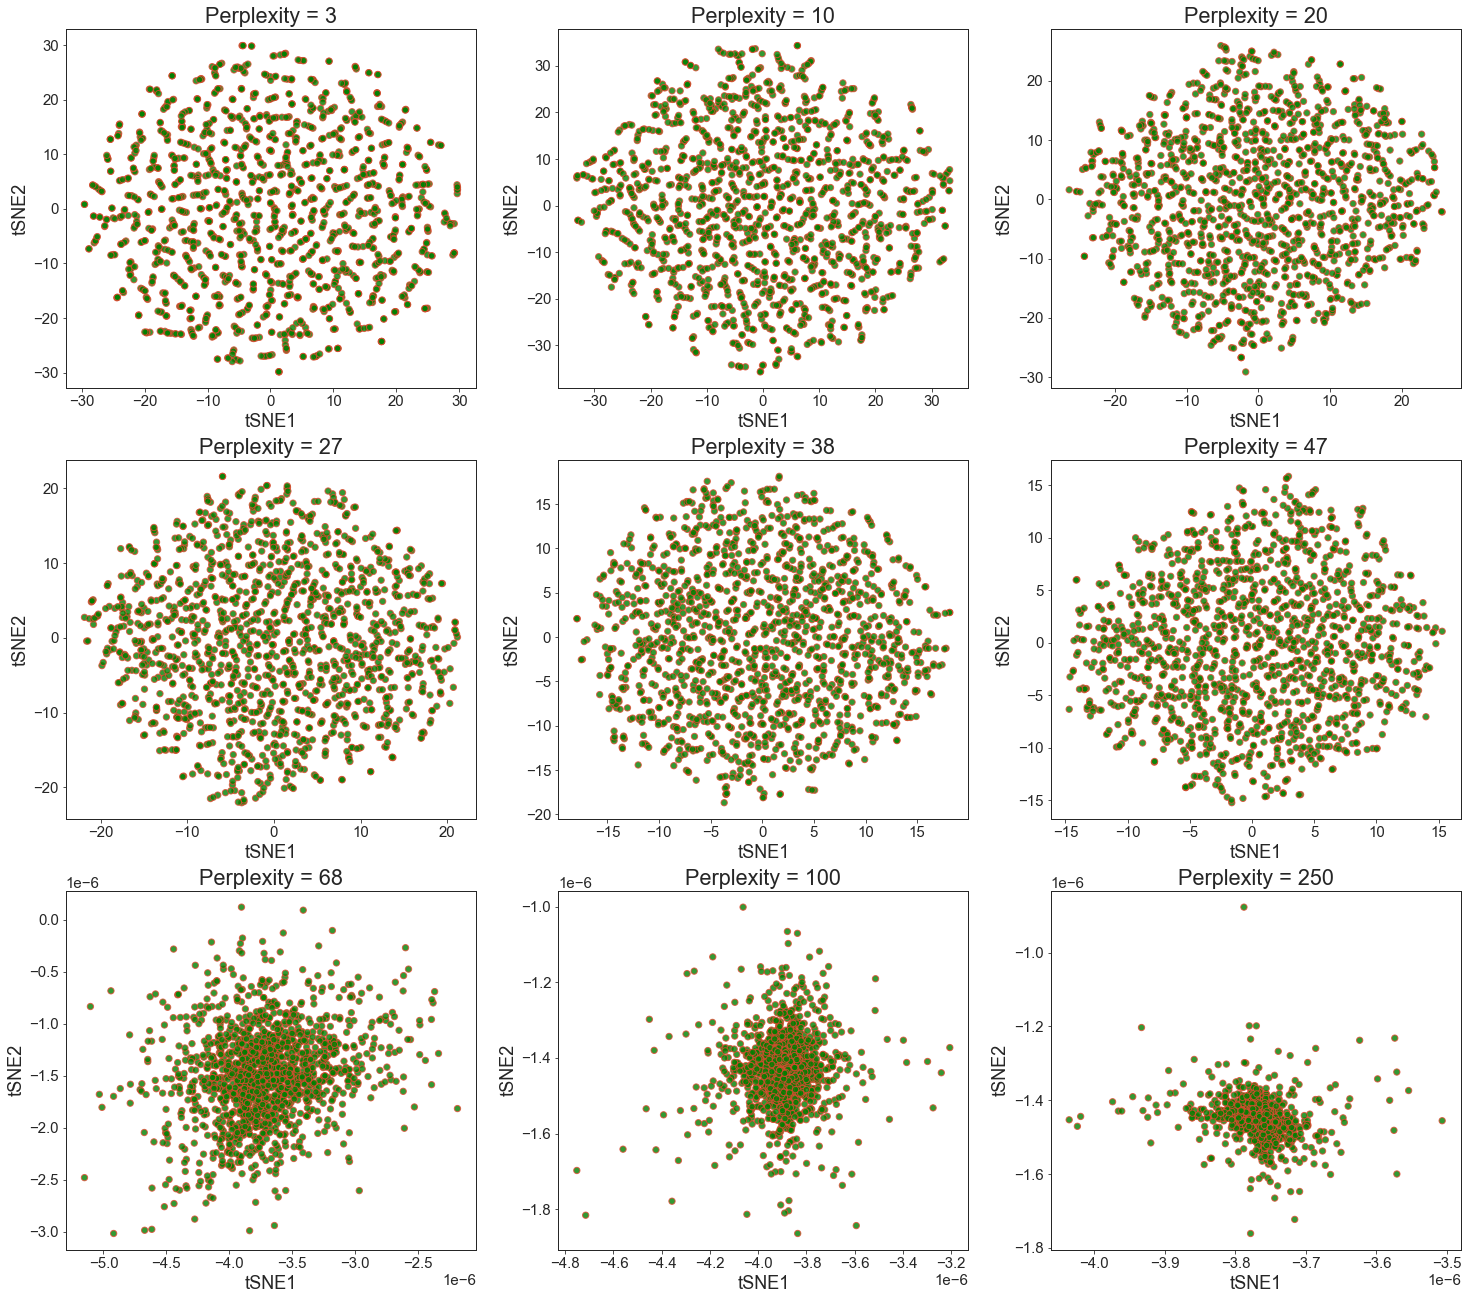

In [34]:
check_perplexity([3,10,20,27,38,47,68,100,250],model_t,list_names,size)

### How to tune hyperparameters of tSNE 

__VERY HELPFUL RESOURCE__:(tSNE and Permutation for PCA)
https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868

### t-SNE visualizations (Plotting the clusters):

A very good read on t-SNE visualizations:<br>
https://distill.pub/2016/misread-tsne/<br>

Unfortunately I could not observe any clusters here: 

In [70]:
def tsnescatterplot(model, word,list_names,size):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, size), dtype='f')
    word_labels = []
    color_list  = []
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        try:
            wrd_vector = model.wv.__getitem__([wrd])
            word_labels.append(wrd)
            color_list.append('green')
            arrays = np.append(arrays, wrd_vector, axis=0)
        except Exception:
            pass
        
    # Reduces the dimensionality with PCA
    pca = PCA(n_components=10).fit(arrays)
    reduc = pca.transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, perplexity=50, learning_rate=10,verbose=3,
                  n_iter=500, random_state=0, angle=0.75).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(6, 6)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                 'facecolors': df['color']})
                    
    # Adds annotations one by one with a loop
#     for line in range(0, df.shape[0]):
#          p1.text(df["x"][line],
#                  df['y'][line],
#                  '  ' + df["words"][line].title(),
#                  horizontalalignment='left',
#                  verticalalignment='bottom', size='medium',
#                  weight='normal'
#                 ).set_size(10)

    
    plt.xlim(Y[:, 0].min()-1, Y[:, 0].max()+1)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()+1)
            
    plt.title('t-SNE visualization')
    fig.savefig('{}.png'.format('tsne'), bbox_inches='tight')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.000s...
[t-SNE] Computed neighbors for 300 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.017601
[t-SNE] Computed conditional probabilities in 0.033s
[t-SNE] Iteration 50: error = 49.8389664, gradient norm = 0.0000000 (50 iterations in 0.126s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 49.838966
[t-SNE] Iteration 100: error = 1.3567815, gradient norm = 0.0119860 (50 iterations in 0.129s)
[t-SNE] Iteration 150: error = 1.1690767, gradient norm = 0.0018046 (50 iterations in 0.124s)
[t-SNE] Iteration 200: error = 1.1551443, gradient norm = 0.0009749 (50 iterations in 0.137s)
[t-SNE] Iteration 250: error = 1.1494024, gradient norm = 0.0006637 (50 iterations in 0.136s)
[t-SNE] Iteration 300: error = 1.1445818, gradient norm = 0.0005864 (50 iterations in 0.109s)
[t-SNE] Iteration

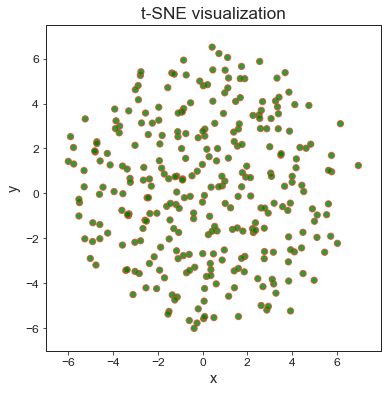

In [71]:
tsnescatterplot(model_t, 'global warm', list_names,size)

## Anchored Correlated Topic Modeling 

In [114]:
anchor_words = ['global warm','solar','coal','nuclear','energy']

In [115]:
anchored_topic_model = ct.Corex(n_hidden=TOPICS, seed=2)
anchored_topic_model.fit(tfidf,docs=corpus,words=vocab, anchors=anchor_words, anchor_strength=6);

In [116]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: global warm,global,warm,chang,climat chang,climat,weather,warm link,gore,snow
1: solar,snowi,warm unequivoc,unequivoc,discoveri techniqu,drug discoveri,techniqu,drug,discoveri,lesson
2: coal,chang clinic,trial,clinic,clinic trial,trial collagen,collagen,scream climat,scream,collagen cliniqu
3: nuclear,nuclear power,power,nuclear energi,power plant,plant,energi,link,japan,fukushima
4: iceland,california,volcano,law,volcan,iceland volcano,warm law,california global,erupt,volcan erupt


In [117]:
anchored_topic_model.tc

25.444197264245528

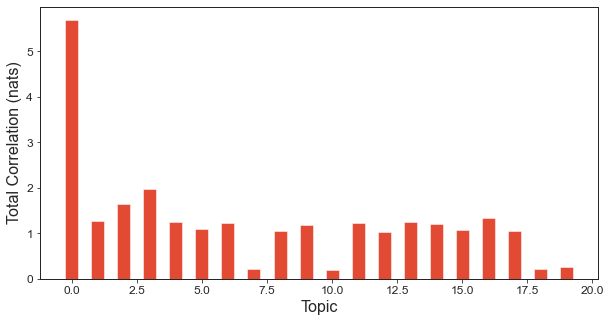

In [118]:
plt.figure(figsize=(10,5))
plt.bar(range(anchored_topic_model.tcs.shape[0]), anchored_topic_model.tcs, width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [119]:
from collections import defaultdict

In [120]:
color_list = ['blue','green','red','black','purple']
sentences_anchored = []
dic = defaultdict()
for i in range(len(anchor_words)):
    words,mis = zip(*anchored_topic_model.get_topics(n_words=NBR_OF_WORDS,topic=i))
    dic.update({word:color_list[i] for word in words})
    sentences_anchored.append(list(words))

In [121]:
bigram = Phrases(sentences_anchored, min_count=1, threshold=0.8, scoring='npmi')

In [128]:
trigram = Phrases(bigram[sentences_anchored])
fourgram = Phrases(trigram[sentences_anchored])

In [129]:
text_anchored = list(bigram[sentences_anchored])

In [130]:
model_anchored = gensim.models.Word2Vec(text_anchored, min_count = 1,size = size, window = 5) 

In [131]:
list_names_anchored = model_anchored.wv.vocab

In [132]:
def tsnescatterplot(model,list_names,size,color_dic):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, size), dtype='f')
    word_labels = []
    color = []
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color.append(color_dic[wrd])
        arrays = np.append(arrays, wrd_vector, axis=0)
        
        
    # Reduces the dimensionality with PCA
#     pca = PCA(n_components=10).fit(arrays)
#     reduc = pca.transform(arrays)
    reduc = arrays
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, perplexity=20, learning_rate=10,verbose=3,
                  n_iter=1000, random_state=0, angle=0.75).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(8, 8)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                 'facecolors': df['color']})
                    
    
    # Adds annotations one by one with a loop
#     for line in range(0, df.shape[0]):
#          p1.text(df["x"][line],
#                  df['y'][line],
#                  '  ' + df["words"][line].title(),
#                  horizontalalignment='left',
#                  verticalalignment='bottom', size='medium',
#                  weight='normal'
#                 ).set_size(10)

    
#     plt.xlim(Y[:, 0].min()-3, Y[:, 0].max()+3)
#     plt.ylim(Y[:, 1].min()-3, Y[:, 1].max()+3)
            
    plt.title('t-SNE visualization')
    fig.savefig('{}.png'.format('tsne_anchored'), bbox_inches='tight')

In [133]:
tsnescatterplot(model_anchored,list_names_anchored,size,dic)

dict_keys(['global warm_global', 'warm_chang', 'climat chang_climat', 'weather_warm link', 'gore_snow', 'al gore_al', 'dc_chang link', 'stop global_sunshin', 'sunni_warm caus', 'say global_pm', 'great global_scientist', 'blame_silli', 'warm becaus_blame global', 'warm hoax_chang legisl', 'caus global_believ global', 'solar_snowi', 'warm unequivoc_unequivoc', 'discoveri techniqu_drug discoveri', 'techniqu_drug', 'discoveri_lesson', 'joseph_jonah', 'world indigen_cochabamba summit', 'block epa_lesson world', 'battl_battl global', 'mann_block', 'gear_water war', 'ocean chemistri_backlash effort', 'climat action_chemistri', 'solar power_war climat', 'video creator_scientist mann', 'coal_chang clinic', 'trial_clinic', 'clinic trial_trial collagen', 'collagen_scream climat', 'scream_collagen cliniqu', 'cliniqu_cliniqu clip', 'clip_clip art', 'collag_trial collag', 'art_art cloth', 'collagen link_valentin day', 'valentin_collag link', 'coal ceo_climat deal', 'prospect climat_prospect', 'rule_

KeyError: 'global warm_global'